In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyearth import Earth
%matplotlib inline

### Conclusions

Logistic (3000 iters, C=0.5): f1-score \[0.56356 0.52548 0.40789 0.38168\] macro average 0.46965

LinearSVC (2500 iters): f1-score \[0.28694 0.38462 0.12632 0.00000\] average 0.19947

Linear Regressor: f1-score \[0.52228 0.47415 0.27381 0.24000\] average 0.37756

LinearSVR (C=0.5, loss='squared_epsilon_insensitive'): f1-score \[0.45958 0.4374 0.25000 0.25000\]

KNN Regressor: f1-score \[0.51948 0.47966 0.37037 0.28571\] average 0.41381

SVR + Nystroem(kernel='poly', degree=3): f1-score \[0.53348 0.51460 0.39583 0.30435\] average 0.43707

SplineTransformer + SVR + Nystroem(kernel='poly', degree=3): f1-score \[0.60324 0.57485 0.37634 0.30918\] average 0.46590

MARS (degree=3, max_terms=500): f1-score \[0.60397 0.55282 0.46154 0.39640\] average 0.50368

MARS (degree=4, max_terms=500): f1-score \[0.60945 0.56110 0.47500 0.40000\] average **0.51139**

In [2]:
# read Dataset as Pandas DataFrame
print("================ Reading dataset ===============")
dataset = pd.read_pickle('../Dataset/baseline_dataset_newvars.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

================ Reading dataset ===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45293 entries, 0 to 45292
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MM             45293 non-null  int64  
 1   DD             45293 non-null  int64  
 2   LOW_IMPACT     45293 non-null  bool   
 3   MID_IMPACT     45293 non-null  bool   
 4   BIG_IMPACT     45293 non-null  bool   
 5   DIRECT_STRIKE  45293 non-null  bool   
 6   DIST00         45293 non-null  float64
 7   AZM00          45293 non-null  float64
 8   SPEED00        45293 non-null  int32  
 9   DIR00          45293 non-null  int32  
 10  VMAX00         45293 non-null  int32  
 11  DVMAX00        45293 non-null  int32  
 12  DIST06         45293 non-null  float64
 13  AZM06          45293 non-null  float64
 14  SPEED06        45293 non-null  int32  
 15  DIR06          45293 non-null  int32  
 16  VMAX06         45293 non-null  int32  
 17  D

In [3]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

# Constants
TRAIN_RATIO = 0.9

In [4]:
# test-dev-train split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,2:6]).astype(int)
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, TRAIN_RATIO)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 36686; Dev set size: 4077; Testing set size: 4530


### Tools

In [5]:
# finds the best decision thresholds and the corresponding F1 scores
# shows the precision-recall curve as well
def optimize_thresholds(clf, datasetX, datasetY):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = clf.predict_proba(datasetX)
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))
    
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
        
    return best_thresholds, best_f1_scores

# make predictions according to the given thresholds
def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [6]:
# new utility functions
from scipy.special import expit

def regression_predict(regr, datasetX, method='sigmoid'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='sigmoid'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='sigmoid'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

### Solid proof that PCA and Poly features don't always work

In [7]:
# imports
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem, PolynomialCountSketch
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

In [8]:
poly = PolynomialFeatures(degree=3, include_bias=False)
transformed_X = poly.fit_transform(train_X)

transformed_X.shape

(36686, 5983)

In [9]:
std_X = StandardScaler().fit(transformed_X)
standard_X = std_X.transform(transformed_X)
pca = PCA(n_components=450)
pca.fit(standard_X)

MemoryError: Unable to allocate 13.0 GiB for an array with shape (36317, 47904) and data type float64

### Classifiers

In [9]:
basic_clf_1 = OneVsRestClassifier(LogisticRegression(
    max_iter=3000, C=0.5
), n_jobs=-1)

basic_clf_1 = basic_clf_1.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, basic_clf_1.predict(train_X))))

# test model on dev set
preds = basic_clf_1.predict(dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0))

Training accuracy: 0.8831161751
Accuracy of classifier on dev set: 0.8950208487
              precision    recall  f1-score   support

           0       0.61      0.29      0.40       356
           1       0.66      0.35      0.46       262
           2       0.67      0.21      0.32        87
           3       0.83      0.07      0.13        72

   micro avg       0.64      0.28      0.39       777
   macro avg       0.69      0.23      0.33       777
weighted avg       0.65      0.28      0.38       777
 samples avg       0.03      0.03      0.03       777



Best Threshold=0.28521, F-Score=0.56545
Best Threshold=0.24140, F-Score=0.52782
Best Threshold=0.33906, F-Score=0.41830
Best Threshold=0.24596, F-Score=0.39394


/tmp/.u3556490/ipykernel_428/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


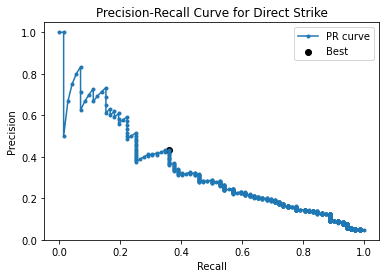

In [10]:
best_thresholds, best_f1_scores = optimize_thresholds(basic_clf_1, dev_X, dev_Y)

In [11]:
preds = predictions_with_thresholds(basic_clf_1, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.52826   0.60393   0.56356       356
           1    0.45082   0.62977   0.52548       262
           2    0.47692   0.35632   0.40789        87
           3    0.42373   0.34722   0.38168        72

   micro avg    0.48606   0.56113   0.52091       777
   macro avg    0.46993   0.48431   0.46965       777
weighted avg    0.48671   0.56113   0.51644       777
 samples avg    0.05288   0.06079   0.05291       777



In [15]:
from sklearn.svm import LinearSVC

basic_clf_2 = OneVsRestClassifier(LinearSVC(dual=False, max_iter=2500), n_jobs=-1)

basic_clf_2 = basic_clf_2.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, basic_clf_2.predict(train_X))))

# test model on dev set
preds = basic_clf_2.predict(dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Training accuracy: 0.8840974759
Accuracy of classifier on dev set: 0.8903605592
              precision    recall  f1-score   support

           0    0.60360   0.18820   0.28694       356
           1    0.68627   0.26718   0.38462       262
           2    0.75000   0.06897   0.12632        87
           3    0.00000   0.00000   0.00000        72

   micro avg    0.64706   0.18404   0.28657       777
   macro avg    0.50997   0.13109   0.19947       777
weighted avg    0.59194   0.18404   0.27530       777
 samples avg    0.02146   0.01846   0.01862       777



### Regressors

In [9]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

linear_regr = MultiOutputRegressor(LinearRegression(), n_jobs=-1)
linear_regr = linear_regr.fit(train_X, train_Y)

Best Threshold=0.55215, F-Score=0.52410
Best Threshold=0.54128, F-Score=0.47607
Best Threshold=0.52001, F-Score=0.27893
Best Threshold=0.51421, F-Score=0.24779


/tmp/.u3556490/ipykernel_428/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_428/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_428/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


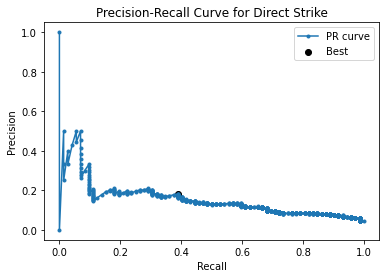

In [17]:
best_thresholds, best_f1_scores = regressor_find_thresholds(linear_regr, dev_X, dev_Y, 'sigmoid')

In [18]:
preds = regression_label(linear_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.46681   0.59270   0.52228       356
           1    0.35405   0.71756   0.47415       262
           2    0.18474   0.52874   0.27381        87
           3    0.17647   0.37500   0.24000        72

   micro avg    0.34079   0.60746   0.43663       777
   macro avg    0.29552   0.55350   0.37756       777
weighted avg    0.37030   0.60746   0.45207       777
 samples avg    0.04765   0.06588   0.05116       777



In [10]:
from sklearn.svm import LinearSVR

svr_regr = MultiOutputRegressor(LinearSVR(loss='squared_epsilon_insensitive', dual=False, C=0.5), n_jobs=-1)

svr_regr = svr_regr.fit(train_X, train_Y)

Best Threshold=0.55098, F-Score=0.45958
Best Threshold=0.54004, F-Score=0.43743
Best Threshold=0.52966, F-Score=0.25000
Best Threshold=0.51480, F-Score=0.25000


/tmp/.u3556490/ipykernel_428/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


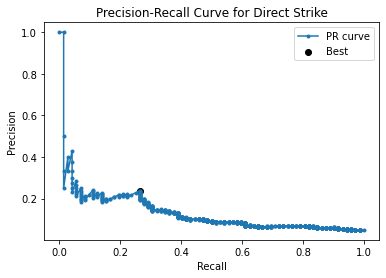

In [21]:
best_thresholds, best_f1_scores = regressor_find_thresholds(svr_regr, dev_X, dev_Y, 'sigmoid')

In [22]:
from sklearn.neighbors import KNeighborsRegressor

knr_regr = MultiOutputRegressor(KNeighborsRegressor(), n_jobs=-1)

knr_regr = knr_regr.fit(train_X, train_Y)

Best Threshold=0.59869, F-Score=0.55594
Best Threshold=0.59869, F-Score=0.55484
Best Threshold=0.59869, F-Score=0.44554
Best Threshold=0.59869, F-Score=0.31724


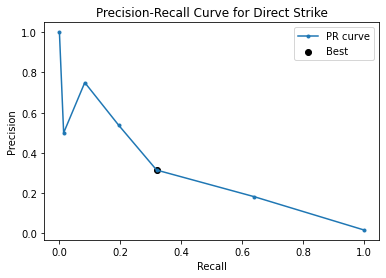

In [23]:
best_thresholds, best_f1_scores = regressor_find_thresholds(knr_regr, dev_X, dev_Y, 'sigmoid')

In [24]:
preds = regression_label(knr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.61538   0.44944   0.51948       356
           1    0.54634   0.42748   0.47966       262
           2    0.52083   0.28736   0.37037        87
           3    0.53846   0.19444   0.28571        72

   micro avg    0.57699   0.40026   0.47264       777
   macro avg    0.55526   0.33968   0.41381       777
weighted avg    0.57439   0.40026   0.46769       777
 samples avg    0.04779   0.04317   0.04281       777



In [14]:
from sklearn.preprocessing import SplineTransformer

svr_regr = MultiOutputRegressor(LinearSVR(loss='squared_epsilon_insensitive', dual=False, C=0.5), n_jobs=-1)

pipe = make_pipeline(
    SplineTransformer(include_bias=False),
    # PolynomialFeatures(),
    StandardScaler(),
    Nystroem(kernel='poly', degree=3),
    # PolynomialCountSketch(degree=3, n_components=300),
    svr_regr, verbose=True
)
print(pipe)

poly_svr_regr = pipe.fit(train_X, train_Y)

Pipeline(steps=[('splinetransformer', SplineTransformer(include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('nystroem', Nystroem(degree=3, kernel='poly')),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=LinearSVR(C=0.5, dual=False,
                                                          loss='squared_epsilon_insensitive'),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline] . (step 1 of 4) Processing splinetransformer, total=   0.4s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.1s
[Pipeline] .......... (step 3 of 4) Processing nystroem, total=   0.4s
[Pipeline]  (step 4 of 4) Processing multioutputregressor, total=   3.6s


Best Threshold=0.56758, F-Score=0.60475
Best Threshold=0.56148, F-Score=0.57698
Best Threshold=0.56457, F-Score=0.38503
Best Threshold=0.53691, F-Score=0.31731


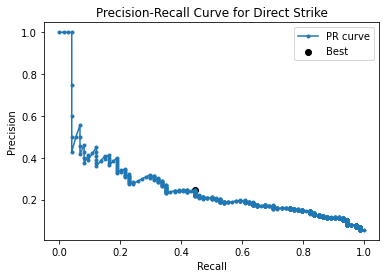

In [15]:
best_thresholds, best_f1_scores = regressor_find_thresholds(poly_svr_regr, dev_X, dev_Y, 'sigmoid')

In [16]:
preds = regression_label(poly_svr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.52150   0.71538   0.60324       390
           1    0.48608   0.70330   0.57485       273
           2    0.41176   0.34653   0.37634       101
           3    0.24060   0.43243   0.30918        74

   micro avg    0.46864   0.64200   0.54179       838
   macro avg    0.41498   0.54941   0.46590       838
weighted avg    0.47193   0.64200   0.54068       838
 samples avg    0.06623   0.07463   0.06504       838



### Ultimate weapon: Regression splines
#### MARS

In [38]:
earth_regr = MultiOutputRegressor(Earth(max_degree=4, max_terms=500, use_fast=True), n_jobs=-1)
earth_regr = earth_regr.fit(train_X, train_Y)

Best Threshold=0.57382, F-Score=0.61118
Best Threshold=0.56688, F-Score=0.56357
Best Threshold=0.57861, F-Score=0.48447
Best Threshold=0.56474, F-Score=0.41509


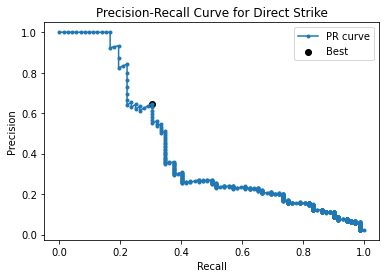

In [39]:
best_thresholds, best_f1_scores = regressor_find_thresholds(earth_regr, dev_X, dev_Y, 'sigmoid')

In [40]:
preds = regression_label(earth_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.54688   0.68820   0.60945       356
           1    0.51097   0.62214   0.56110       262
           2    0.52055   0.43678   0.47500        87
           3    0.63636   0.29167   0.40000        72

   micro avg    0.53494   0.60103   0.56606       777
   macro avg    0.55369   0.50970   0.51139       777
weighted avg    0.54011   0.60103   0.55869       777
 samples avg    0.06392   0.06831   0.06210       777

